In [50]:
# Speed and stress - Figure 11

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyproj import Transformer
from matplotlib import cm
from datetime import datetime
from pyproj import Transformer
from scipy.ndimage import convolve

# right now, this loads the output into ds_CSYV
%run -i ncbx_funcs.py

Shape of xisl, yisl:  (1057, 1317) (1057, 1317)
Index of shoreline and y-location:
[168] [329.27781985]
Offshore model domain (dy_offshore):  [4453.85735021] , onshore (dy_onshore):  [5530.01136684]


In [2]:
eta_rho = ds_CSYV.sizes['eta_rho']
xi_rho = ds_CSYV.sizes['xi_rho']
s_rho = ds_CSYV.sizes['s_rho']
print(f"eta_rho = {eta_rho}, xi_rho = {xi_rho}")
print(f"s_rho = {s_rho}")
print(np.shape(xisl))

eta_rho = 1057, xi_rho = 1317
s_rho = 8
(1057, 1317)


In [3]:
# contour levels
levels = np.array( [-6, -4, -2, 0., 2.] ) # bathy
zlevels = np.arange(1, 2.75, .25) # water levels

# Smoothing kernal
ik = 15
k = np.ones((ik, ik)) / (ik*ik)

# pick a time index
# 0, 19, and 31
idx = 19
#for idx in np.arange(0, len(tstring), 2 ):

# Zoom in
xs = 950
xe = 1650
ys = -150
ye = 450

# load bathy and smooth for contouring
bath = np.squeeze( -ds_CSYV.bath[idx,:,:].load().values )
baths = convolve(bath,k,mode='nearest')

# load water elevation and mask dry regions
zeta = np.squeeze( ds_CSYV.zeta[idx,:,:].load().values )
wdm = np.squeeze( ds_CSYV.wetdry_mask_rho[idx,:,:].load().values )
zeta = despeckle( mask_array( zeta, wdm ) )

bustrc = np.squeeze( ds_CSYV.bustrc[idx,:,:].load().values )
bustrw = np.squeeze( ds_CSYV.bustrw[idx,:,:].load().values )
bvstrc = np.squeeze( ds_CSYV.bvstrc[idx,:,:].load().values )
bvstrw = np.squeeze( ds_CSYV.bvstrw[idx,:,:].load().values )
ustrc = np.sqrt(bustrc**2+bvstrc**2)
ustrw = np.sqrt(bustrw**2+bvstrw**2)
taucw = np.sqrt( ustrc**2 + ustrw**2)

ustrc = despeckle( mask_array( ustrc, wdm ) )
ustrw = despeckle( mask_array( ustrw, wdm ) )
taucw = despeckle( mask_array( taucw, wdm ) )
print('max ustrc:',np.nanmax(ustrc))
print('max ustrw:',np.nanmax(ustrw))
print('max taucw:',np.nanmax(taucw))

# load velocities
u = despeckle( mask_array( np.squeeze( ds_CSYV.ubar[idx,:,:].load().values),
                          np.squeeze( ds_CSYV.wetdry_mask_u[idx,:,:].load().values) ) )
v = despeckle( mask_array( np.squeeze( ds_CSYV.vbar[idx,:,:].load().values), 
                          np.squeeze( ds_CSYV.wetdry_mask_v[idx,:,:].load().values) ) )

uc = 0.5 * (u[0:-1,:]+u[1:,:])
vc = 0.5 * (v[:,0:-1]+v[:,1:])
# vc = np.pad(vc, ( (0,0), (1,1)), mode='edge')
# uc = np.pad(uc, ( (1,1), (0,0)), mode='edge')
print('uc:',np.shape(uc))
print('vc:',np.shape(vc))

max ustrc: 59.194168
max ustrw: 16.190924
max taucw: 59.194168
uc: (1056, 1316)
vc: (1056, 1316)


In [52]:
# loop through all timesteps in the local version and extract max streses
# this overwrites idx...be sure to set it again
ds_CSYVc = xr.open_dataset( url_CSYVc )
nt = len( tstring )
print(nt)
mx_ustrc = []
mx_ustrw = []
mx_taucw = []
mx_spd = []

for idx, tstr in enumerate( tstring ):
    bustrc = np.squeeze( ds_CSYVc.bustrc[idx,:,:].load().values )
    bustrw = np.squeeze( ds_CSYVc.bustrw[idx,:,:].load().values )
    bvstrc = np.squeeze( ds_CSYVc.bvstrc[idx,:,:].load().values )
    bvstrw = np.squeeze( ds_CSYVc.bvstrw[idx,:,:].load().values )
    ustrc = np.sqrt(bustrc**2+bvstrc**2)
    ustrw = np.sqrt(bustrw**2+bvstrw**2)
    taucw = np.sqrt( ustrc**2 + ustrw**2)

    mx_ustrc.append( np.nanmax(ustrc))
    mx_ustrw.append( np.nanmax(ustrw))
    mx_taucw.append( np.nanmax(taucw))
    
    # load velocities
    u = mask_array( np.squeeze( ds_CSYVc.ubar[idx,:,:].load().values),
                    np.squeeze( ds_CSYV.wetdry_mask_u[idx,:,:].load().values) ) 
    v = mask_array( np.squeeze( ds_CSYVc.vbar[idx,:,:].load().values), 
                    np.squeeze( ds_CSYV.wetdry_mask_v[idx,:,:].load().values) )
    
    uc = 0.5 * (u[0:-1,:]+u[1:,:])
    vc = 0.5 * (v[:,0:-1]+v[:,1:])
    spd = np.sqrt( uc**2 + vc**2 )
    mx_spd.append( np.nanmax(spd))

print('Max. speed: ', np.max( mx_spd ) )
print('Max. ustrc: ', np.max( mx_ustrc ) )
print('Max. ustrw: ', np.max( mx_ustrw ) )
print('Max. tauc: ', np.max( mx_taucw ) )

37
Max. speed:  6.7893777
Max. ustrc:  151.7739
Max. ustrw:  21.233093
Max. tauc:  151.7739


In [53]:
# when is the max speed and stress?
imax_spd = np.argmax( mx_spd )
print(imax_spd)
imax_taucw = np.argmax( mx_taucw )
print(imax_taucw)
print( tstring[imax_taucw] )

11
11
2019-09-06 13:00


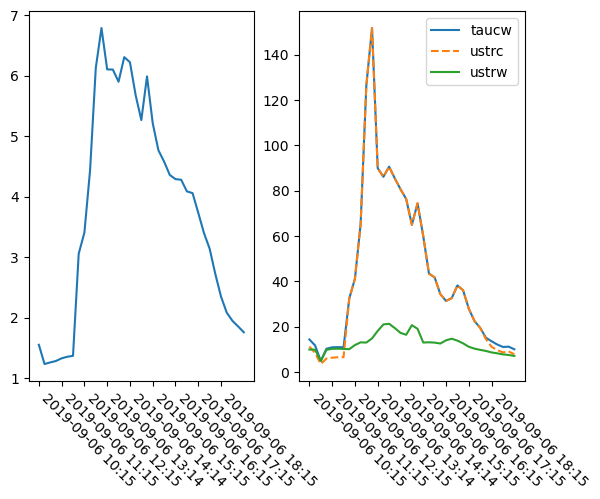

In [77]:
fig, ax  = plt.subplots( 1, 2 , sharex=True)
ax[0].plot( t, mx_spd )
xlabels = tstring[0:-1:4]
ax[0].set_xticks(xticks, xlabels, rotation=-45, ha='left')

ax[1].plot( t, mx_taucw, '-', label='taucw' )
ax[1].plot( t, mx_ustrc, '--', label='ustrc' )
ax[1].plot( t, mx_ustrw, '-', label='ustrw' )
plt.legend()
xticks = t[0:-1:4]
ax[1].set_xticks(xticks, xlabels, rotation = -45, ha='left')


In [66]:
xlabels

Index(['2019-09-06 10:15', '2019-09-06 11:15', '2019-09-06 12:15',
       '2019-09-06 13:14', '2019-09-06 14:14', '2019-09-06 15:15',
       '2019-09-06 16:15', '2019-09-06 17:15', '2019-09-06 18:15'],
      dtype='object')

max spd: 5.411555
max taucw: 74.41308
max ustrc: 74.41308
max ustrw: 19.018486
taucw - ustrc 1.301934
xd: (1057, 1317)
yd: (1057, 1317)
ud: (1056, 1316)
vd: (1056, 1316)


C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_17708\4234990905.py:67: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m2 = ax2.pcolormesh(xisl, yisl, taucw, cmap='magma', vmin=0, vmax=60)
C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_17708\4234990905.py:79: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m3 = ax3.pcolormesh(xd, yd, ustrc, cmap='magma',vmin=0, vmax=60, alpha = .9, zorder=0)
C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_17708\4234990905.py:91: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasin

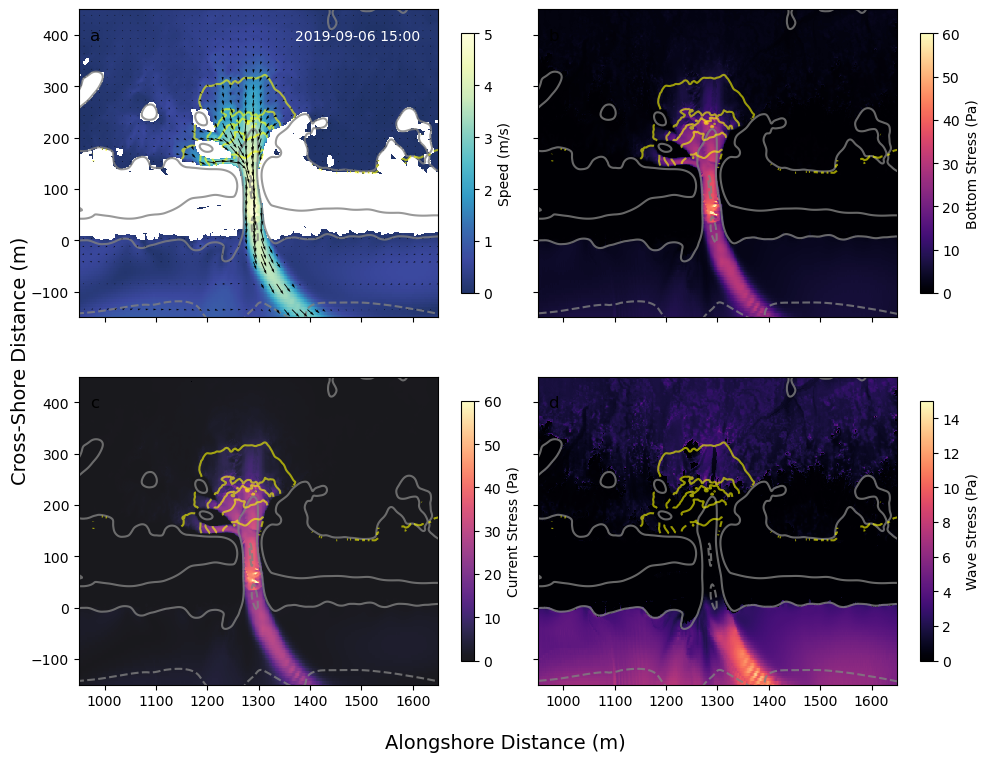

In [55]:
idx = 19
bustrc = np.squeeze( ds_CSYVc.bustrc[idx,:,:].load().values )
bustrw = np.squeeze( ds_CSYVc.bustrw[idx,:,:].load().values )
bvstrc = np.squeeze( ds_CSYVc.bvstrc[idx,:,:].load().values )
bvstrw = np.squeeze( ds_CSYVc.bvstrw[idx,:,:].load().values )
ustrc = np.sqrt(bustrc**2+bvstrc**2)
ustrw = np.sqrt(bustrw**2+bvstrw**2)
taucw = np.sqrt( ustrc**2 + ustrw**2)
# load velocities
u = despeckle( mask_array( np.squeeze( ds_CSYVc.ubar[idx,:,:].load().values),
                np.squeeze( ds_CSYV.wetdry_mask_u[idx,:,:].load().values) ) )
v = despeckle( mask_array( np.squeeze( ds_CSYVc.vbar[idx,:,:].load().values), 
                np.squeeze( ds_CSYV.wetdry_mask_v[idx,:,:].load().values) ) )

uc =  0.5 * (u[0:-1,:]+u[1:,:])
vc =  0.5 * (v[:,0:-1]+v[:,1:])
spd = np.sqrt( uc**2 + vc**2 )
print('max spd:',np.nanmax(spd))

print('max taucw:',np.nanmax(taucw))
print('max ustrc:',np.nanmax(ustrc))
print('max ustrw:',np.nanmax(ustrw))

print('taucw - ustrc',np.nanmean(taucw-ustrc))


# decimate velocities (for some reason, this makes u, v, and x, y the same shape
dfac = 1
xd = xisl[::dfac, ::dfac]
yd = yisl[::dfac, ::dfac]
ud = uc[::dfac, ::dfac]
vd = vc[::dfac, ::dfac]

ddfac = 10
udd = uc[::ddfac, ::ddfac]
vdd = vc[::ddfac, ::ddfac]
xdd = xisl[::ddfac, ::ddfac]
ydd = yisl[::ddfac, ::ddfac]
# scale vector near bottom left is 2 m/s
udd[2,5]=4.
vdd[2,5]=0.

print('xd:',np.shape(xd))
print('yd:',np.shape(yd))
print('ud:',np.shape(ud))
print('vd:',np.shape(vd))

abcde = ['a','b','c','d','e','f']

fig, axes  = plt.subplots(2, 2,figsize=(10,8),sharey=True, sharex=True)
ax1, ax2, ax3, ax4 = axes.ravel()
plt.subplots_adjust(hspace=0.1, wspace=0.1)
m1 = ax1.pcolormesh(xd, yd, spd, cmap='YlGnBu_r',vmin=0, vmax=5, alpha = .9, zorder=0)
m1c = ax1.contour(xisl,yisl,baths,levels,colors='gray',vmin=-2,vmax=5, alpha=.8, zorder=1)
ax1.quiver(xdd, ydd, udd, vdd, color='black', alpha=1, zorder=2,scale=1./7., scale_units='xy', angles='xy')
m1s = ax1.contour(xd, yd, zeta, zlevels, colors='yellow',vmin=0, vmax=2.5, alpha = .6, zorder=1)
ax1.text(.03, .9, abcde[0], fontsize=12, transform=ax1.transAxes )

cbar1 = plt.colorbar(m1, ax=ax1, shrink=.65)
cbar1.set_label(r'Speed (m/s)', rotation=90)

ax1.set_xlim([xs, xe])
ax1.set_ylim([ys, ye])
ax1.set_aspect('equal')
ax1.text(0.95, 0.9, r'{}'.format(tstring[idx]), transform=ax1.transAxes, ha='right', c='white')

m2 = ax2.pcolormesh(xisl, yisl, taucw, cmap='magma', vmin=0, vmax=60)
m2c = ax2.contour(xisl,yisl,baths,levels,colors='gray',vmin=-2,vmax=5, alpha=.8, zorder=1)
m2s = ax2.contour(xd, yd, zeta, zlevels, colors='yellow',vmin=0, vmax=2.5, alpha = .6, zorder=1)

ax2.set_xlim([xs, xe])
ax2.set_ylim([ys, ye])
ax2.set_aspect('equal')
cbar2 = plt.colorbar(m2, ax=ax2, shrink=.65)
cbar2.set_label(r'Bottom Stress (Pa)', rotation=90)
#ax2.text(0.95, 0.9, r'{}'.format(tstring[idx]), transform=ax2.transAxes, ha='right', c='white')
ax2.text(.03, .9, abcde[1], fontsize=12, transform=ax2.transAxes )

m3 = ax3.pcolormesh(xd, yd, ustrc, cmap='magma',vmin=0, vmax=60, alpha = .9, zorder=0)
m3c = ax3.contour(xisl,yisl,baths,levels,colors='gray',vmin=-2,vmax=5, alpha=.8, zorder=1)
m3s = ax3.contour(xd, yd, zeta, zlevels, colors='yellow',vmin=0, vmax=2.5, alpha = .6, zorder=1)
ax3.text(.03, .9, abcde[2], fontsize=12, transform=ax3.transAxes )

cbar3 = plt.colorbar(m3, ax=ax3, shrink=.65)
cbar3.set_label(r'Current Stress (Pa)', rotation=90)

ax3.set_xlim([xs, xe])
ax3.set_ylim([ys, ye])
ax3.set_aspect('equal')

m4 = ax4.pcolormesh(xisl, yisl, ustrw, cmap='magma', vmin=0, vmax=15)
m4c = ax4.contour(xisl,yisl,baths,levels,colors='gray',vmin=-2,vmax=5, alpha=.8, zorder=1)
m4s = ax4.contour(xd, yd, zeta, zlevels, colors='yellow',vmin=0, vmax=2.5, alpha = .6, zorder=1)
ax4.text(.03, .9, abcde[3], fontsize=12, transform=ax4.transAxes )

ax4.set_xlim([xs, xe])
ax4.set_ylim([ys, ye])
ax4.set_aspect('equal')
cbar4 = plt.colorbar(m4, ax=ax4, shrink=.65)
cbar4.set_label(r'Wave Stress (Pa)', rotation=90)
#x4.set_xlabel('Alongshore Distance (m)')

# Add shared axis labels
fig.supylabel('Cross-Shore Distance (m)', fontsize=14, x=0.005)
fig.supxlabel('Alongshore Distance (m)', fontsize=14)

fig.tight_layout(pad = .25)
plt.show()
fig.savefig('CSYV_4stress.png'.format(idx), dpi=200, bbox_inches='tight')

### Extract z level info

In [56]:
   
#Hz=set_depth(Vtransform, Vstretching, theta_s, theta_b, hc, N, igrid, h, zeta, report)
#Hz=set_depth(2, 4, 0, 0, 0, 8, 1, h, zeta, 1
theta_s = ds_CSYV['theta_s'].values.item()
theta_b = ds_CSYV['theta_b'].values.item()
hc = ds_CSYV['hc'].values.item()
Vtransform = ds_CSYV['Vtransform'].values.item()
Vstretching = ds_CSYV['Vstretching'].values.item()
#
zetai = np.squeeze( ds_CSYV.zeta[idx,:,:].load().values )
z_w = set_depth_w(-bath, zetai, hc=hc, N=8, Vtransform=Vtransform,
                   Vstretching=Vstretching, theta_s=theta_s, theta_b=theta_b)
z_rho = set_depth(-bath, zetai, hc=hc, N=8, Vtransform=Vtransform, Vstretching=Vstretching, theta_s=theta_s, theta_b=theta_b, grid='rho')
print(np.shape(z_w))

(9, 1057, 1317)


### Calculate ssc and ssc flux

In [57]:
 # N = 8
N=s_rho
Hz = np.zeros( (N, eta_rho, xi_rho) )
sscu = np.zeros( (N, eta_rho, xi_rho) )
sscv = np.zeros( (N, eta_rho, xi_rho) )
sscc = np.zeros( (N, eta_rho, xi_rho) )

ssc = np.squeeze( ds_CSYVc.sand_01[idx,:,:,:].load().values + \
        ds_CSYVc.sand_02[idx,:,:,:].load().values + \
        ds_CSYVc.sand_03[idx,:,:,:].load().values)
print('ssc:',np.shape(ssc))

ssc: (8, 1057, 1317)


In [59]:
depth = np.sum( Hz, axis=0 )

u_rho = 0.5 * (ds_CSYVc.u[idx, :, :, :-1] + ds_CSYVc.u[idx, :, :, 1:])
v_rho = 0.5 * (ds_CSYVc.v[idx, :, :-1, :] + ds_CSYVc.v[idx, :, 1:, :])
u_rho = np.pad(u_rho, ( (0,0), (0,0), (1,1)), mode='edge')
v_rho = np.pad(v_rho, ( (0,0), (1,1), (0,0)), mode='edge')

for ilevel in range(N):
    Hz[ilevel,:,:] = (z_w[ilevel+1,:,:]-z_w[ilevel,:,:])
    sscc[ilevel,:,:] = ssc[ilevel,:,:] * Hz[ilevel,:,:] 
    sscu[ilevel,:,:] = ssc[ilevel,:,:] * u_rho[ilevel,:,:] * Hz[ilevel,:,:] 
    sscv[ilevel,:,:] = ssc[ilevel,:,:] * v_rho[ilevel,:,:] * Hz[ilevel,:,:] 

print(np.shape(Hz))
print(np.shape(u_rho))
print(np.shape(v_rho))
ssc_avg = np.sum( sscc, axis=0)/depth
sscu_avg = np.sum( sscu, axis=0)/depth
sscv_avg = np.sum( sscv, axis=0)/depth
ssc_flux = np.sqrt( sscu_avg**2 + sscv_avg**2 )

print(np.shape(depth))
print(np.max(depth))
print(np.shape(ssc_avg))
print(np.max(ssc_avg))
print(np.nanmax(ssc_flux))

(8, 1057, 1317)
(8, 1057, 1317)
(8, 1057, 1317)
(1057, 1317)
2.1141297817230225
(1057, 1317)
266.2862854003906
1016.8152282021919


### Read the bedload flux

In [61]:
bdldu = np.squeeze( ds_CSYV.bedload_Usand_01[idx,:,:].load().values ) + \
        np.squeeze( ds_CSYV.bedload_Usand_02[idx,:,:].load().values ) + \
        np.squeeze( ds_CSYV.bedload_Usand_02[idx,:,:].load().values )

bdldv = np.squeeze( ds_CSYV.bedload_Vsand_01[idx,:,:].load().values ) + \
        np.squeeze( ds_CSYV.bedload_Vsand_02[idx,:,:].load().values ) + \
        np.squeeze( ds_CSYV.bedload_Vsand_02[idx,:,:].load().values )

bdldu = despeckle( mask_array( np.squeeze( bdldu ),
                              np.squeeze( ds_CSYV.wetdry_mask_u[idx,:,:].load().values) ) )
bdldv = despeckle( mask_array( np.squeeze( bdldv ), 
                              np.squeeze( ds_CSYV.wetdry_mask_v[idx,:,:].load().values) ) )

bdldu = 0.5 * (bdldu[0:-1,:]+bdldu[1:,:])
bdldv = 0.5 * (bdldv[:,0:-1]+bdldv[:,1:])
bdld = np.sqrt( bdldu**2 + bdldv**2 )

print(np.shape(bdld))
print('Max. bdld: ',np.nanmax( bdld ) )

(1056, 1316)
Max. bdld:  133.12236


In [ ]:
### REDO the above, looping through all time steps
for idx, tstr in enumerate( tstring ):

### Two-panel plot of bedload and sus. load fluxes

In [ ]:
# decimate bedload vectors
# reset idx
idx = 19
dfac = 5
bdldud = bdldu[::dfac, ::dfac]
bdldvd = bdldv[::dfac, ::dfac]
# scale vector near bottom left is 50 kg/m/s
bdldud[4,5]=50.
bdldvd[4,5]=0.
# decimate locations
xd = xisl[::dfac, ::dfac]
yd = yisl[::dfac, ::dfac]

fig, [ax1, ax2]  = plt.subplots(1,2,figsize=(8,6),sharey=True)
ax1.pcolormesh(xisl, yisl, wdm, cmap='binary', alpha=.1, zorder=0 )
m1 = ax1.pcolormesh(xisl, yisl, bdld, cmap='hot_r',vmin=0, vmax=100, alpha = .6, zorder=1)
m1c = ax1.contour(xisl,yisl,baths,levels,colors='gray',linewidth=2, vmin=-2,vmax=5, zorder=2, alpha=1)
#ax1.quiver(xd, yd, bdldud, bdldvd, color='black', alpha=1, zorder=2,scale=1./5., scale_units='xy', angles='xy')
cbar1 = plt.colorbar(m1, ax=ax1, shrink=.35, orientation="vertical")
cbar1.set_label(r'Bedload Flux (kg m$^{-1}$ s$^{-1}$)', rotation='vertical')
# ax1.text(1000,-100,'2 m/s',fontsize=9)
ax1.set_xlim([xs, xe])
ax1.set_ylim([ys, ye])
ax1.set_aspect('equal')
#ax1.text(0.95, 0.9, r'{}'.format(tstring[idx]), color='black', transform=ax1.transAxes, ha='right')
ax1.set_xlabel('Alongshore Distance (m)')
ax1.set_ylabel('Cross-Shore Distance (m)')

m2 = ax2.pcolormesh(xisl, yisl, ssc_flux, cmap='hot_r',vmin=0, vmax=100, alpha = .6, zorder=0)
m2c = ax2.contour(xisl,yisl,baths,levels,colors='gray',linewidth=2, vmin=-2,vmax=5, zorder=1, alpha=1)
# ax1.quiver(xd, yd, bdldud, bdldvd, color='black', alpha=1, zorder=2,scale=1./5., scale_units='xy', angles='xy')
cbar2 = plt.colorbar(m2, ax=ax2, shrink=.35, orientation="vertical")
cbar2.set_label(r'Suspended Flux (kg m$^{-1}$ s$^{-1}$)', rotation='vertical')
# ax2.text(1000,-100,'2 m/s',fontsize=9)
ax2.set_xlim([xs, xe])
ax2.set_ylim([ys, ye])
ax2.set_aspect('equal')
ax2.text(0.95, 0.9, r'{}'.format(tstring[idx]), color='black', transform=ax2.transAxes, ha='right')
ax2.set_xlabel('Alongshore Distance (m)')
fig.savefig('CSYV_bed_sus_fluxes.png'.format(idx), dpi=200, bbox_inches='tight')

### Six-panel plot

In [ ]:

spd = np.sqrt( uc**2 + vc**2 )
print('max spd:',np.nanmax(spd))

print('max taucw:',np.nanmax(taucw))
print('max ustrc:',np.nanmax(ustrc))
print('max ustrw:',np.nanmax(ustrw))
print('mean( taucw - ustrc )',np.nanmean(taucw-ustrc))

print('max bdld:',np.nanmax(bdld))
print('max ssc flux:',np.nanmax(ssc_flux))

# decimate velocities (for some reason, this makes u, v, and x, y the same shape
dfac = 1
xd = xisl[::dfac, ::dfac]
yd = yisl[::dfac, ::dfac]
ud = uc[::dfac, ::dfac]
vd = vc[::dfac, ::dfac]

ddfac = 10
udd = uc[::ddfac, ::ddfac]
vdd = vc[::ddfac, ::ddfac]
xdd = xisl[::ddfac, ::ddfac]
ydd = yisl[::ddfac, ::ddfac]
# scale vector near bottom left is 2 m/s
udd[2,5]=4.
vdd[2,5]=0.

# shrink factor for colorbars
shrink=0.65

fig, axes  = plt.subplots(3, 2,figsize=(10,12),sharey=True, sharex=True)
ax1, ax2, ax3, ax4, ax5, ax6 = axes.ravel()
plt.subplots_adjust(hspace=0.03, wspace=0.05)
m1 = ax1.pcolormesh(xd, yd, spd, cmap='YlGnBu_r',vmin=0, vmax=5, alpha = .9, zorder=0)
m1c = ax1.contour(xisl,yisl,baths,levels,colors='gray',vmin=-2,vmax=5, alpha=.8, zorder=1)
ax1.quiver(xdd, ydd, udd, vdd, color='black', alpha=1, zorder=2,scale=1./7., scale_units='xy', angles='xy')
m1s = ax1.contour(xd, yd, zeta, zlevels, colors='yellow',vmin=0, vmax=2.5, alpha = .6, zorder=1)
ax1.text(.05, .9, abcde[0], fontsize=12, transform=ax1.transAxes, c='white' )

cbar1 = plt.colorbar(m1, ax=ax1, shrink=shrink)
cbar1.set_label(r'Speed (m/s)', rotation=90)

ax1.set_xlim([xs, xe])
ax1.set_ylim([ys, ye])
ax1.set_aspect('equal')
ax1.text(0.95, 0.9, r'{}'.format(tstring[idx]), transform=ax1.transAxes, ha='right', c='white')

m2 = ax2.pcolormesh(xisl, yisl, taucw, cmap='magma', vmin=0, vmax=60)
m2c = ax2.contour(xisl,yisl,baths,levels,colors='gray',vmin=-2,vmax=5, alpha=.8, zorder=1)
m2s = ax2.contour(xd, yd, zeta, zlevels, colors='yellow',vmin=0, vmax=2.5, alpha = .6, zorder=1)

ax2.set_xlim([xs, xe])
ax2.set_ylim([ys, ye])
ax2.set_aspect('equal')
cbar2 = plt.colorbar(m2, ax=ax2, shrink=shrink)
cbar2.set_label(r'Bottom Stress (Pa)', rotation=90)
#ax2.text(0.95, 0.9, r'{}'.format(tstring[idx]), transform=ax2.transAxes, ha='right', c='white')
ax2.text(.05, .9, abcde[1], fontsize=12, transform=ax2.transAxes, c='white' )

m3 = ax3.pcolormesh(xd, yd, ustrc, cmap='magma',vmin=0, vmax=60, alpha = .9, zorder=0)
m3c = ax3.contour(xisl,yisl,baths,levels,colors='gray',vmin=-2,vmax=5, alpha=.8, zorder=1)
m3s = ax3.contour(xd, yd, zeta, zlevels, colors='yellow',vmin=0, vmax=2.5, alpha = .6, zorder=1)
ax3.text(.05, .9, abcde[2], fontsize=12, transform=ax3.transAxes, c='white'  )

cbar3 = plt.colorbar(m3, ax=ax3, shrink=shrink)
cbar3.set_label(r'Current Stress (Pa)', rotation=90)

ax3.set_xlim([xs, xe])
ax3.set_ylim([ys, ye])
ax3.set_aspect('equal')

m4 = ax4.pcolormesh(xisl, yisl, ustrw, cmap='magma', vmin=0, vmax=15)
m4c = ax4.contour(xisl,yisl,baths,levels,colors='gray',vmin=-2,vmax=5, alpha=.8, zorder=1)
m4s = ax4.contour(xd, yd, zeta, zlevels, colors='yellow',vmin=0, vmax=2.5, alpha = .6, zorder=1)
ax4.text(.05, .9, abcde[3], fontsize=12, transform=ax4.transAxes, c='white'  )

ax4.set_xlim([xs, xe])
ax4.set_ylim([ys, ye])
ax4.set_aspect('equal')
cbar4 = plt.colorbar(m4, ax=ax4, shrink=shrink)
cbar4.set_label(r'Wave Stress (Pa)', rotation=90)
#x4.set_xlabel('Alongshore Distance (m)')

ax5.pcolormesh(xisl, yisl, wdm, cmap='binary', alpha=.1, zorder=0 )
m5 = ax5.pcolormesh(xisl, yisl, bdld, cmap='hot_r',vmin=0, vmax=100, alpha = .6, zorder=1)
m5c = ax5.contour(xisl,yisl,baths,levels,colors='gray', vmin=-2,vmax=5, zorder=2, alpha=1)
#ax1.quiver(xd, yd, bdldud, bdldvd, color='black', alpha=1, zorder=2,scale=1./5., scale_units='xy', angles='xy')
ax5.text(.05, .9, abcde[4], fontsize=12, transform=ax5.transAxes, c='black'  )

cbar5 = plt.colorbar(m5, ax=ax5, shrink=shrink, orientation="vertical")
cbar5.set_label(r'Bedload Flux (kg m$^{-1}$ s$^{-1}$)', rotation='vertical')
# ax1.text(1000,-100,'2 m/s',fontsize=9)
ax5.set_xlim([xs, xe])
ax5.set_ylim([ys, ye])
ax5.set_aspect('equal')
#ax1.text(0.95, 0.9, r'{}'.format(tstring[idx]), color='black', transform=ax1.transAxes, ha='right')

ax6.pcolormesh(xisl, yisl, wdm, cmap='binary', alpha=.1, zorder=0 )
m6 = ax6.pcolormesh(xisl, yisl, ssc_flux, cmap='hot_r',vmin=0, vmax=100, alpha = .6, zorder=1)
m6c = ax6.contour(xisl,yisl,baths,levels,colors='gray',linewidth=2, vmin=-2,vmax=5, zorder=2, alpha=1)
# ax1.quiver(xd, yd, bdldud, bdldvd, color='black', alpha=1, zorder=2,scale=1./5., scale_units='xy', angles='xy')
ax6.text(.05, .9, abcde[5], fontsize=12, transform=ax6.transAxes, c='black'  )
cbar6 = plt.colorbar(m6, ax=ax6, shrink=shrink, orientation="vertical")
cbar6.set_label(r'Suspended Flux (kg m$^{-1}$ s$^{-1}$)', rotation='vertical')
# ax2.text(1000,-100,'2 m/s',fontsize=9)
ax6.set_xlim([xs, xe])
ax6.set_ylim([ys, ye])
ax6.set_aspect('equal')
ax6.text(0.95, 0.9, r'{}'.format(tstring[idx]), color='black', transform=ax2.transAxes, ha='right')
fig.savefig('CSYV_6panel_stresses_fluxes.png'.format(idx), dpi=200, bbox_inches='tight')

# Add shared axis labels
fig.supylabel('Cross-Shore Distance (m)', fontsize=14, x=0.05)
fig.supxlabel('Alongshore Distance (m)', fontsize=14, y=.08)

#fig.tight_layout(pad = .25)
plt.show()
fig.savefig('CSYV_bed_sus_fluxes.png'.format(idx), dpi=200, bbox_inches='tight')

In [ ]:
# Make 3d array of SSC, BDLD flux, SSC flux